In [ ]:
# Installation cell
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.0/julia-1.0.5-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
Precompiling project...


In [ ]:
using Pkg

pkg"add Plots; precompile;"
using Plots

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
 Installed NaNMath ──────────── v0.3.3
 Installed Requires ─────────── v0.5.2
 Installed ColorTypes ───────── v0.8.0
 Installed Plots ────────────── v0.28.2
 Installed DataStructures ───── v0.17.6
 Installed RecipesBase ──────── v0.7.0
 Installed Contour ──────────── v0.5.1
 Installed GR ───────────────── v0.44.0
 Installed Showoff ──────────── v0.3.1
 Installed DataAPI ──────────── v1.1.0
 Installed Reexport ─────────── v0.2.0
 Installed FixedPointNumbers ── v0.6.1
 Installed GeometryTypes ────── v0.7.6
 Installed PlotUtils ────────── v0.6.1
 Installed FFMPEG ───────────── v0.2.3
 Installed StaticArrays ─────── v0.12.1
 Installed Colors ───────────── v0.9.6
 Installed PlotThemes ───────── v1.0.0
 Installed SortingAlgorithms ── v0.3.1
 Installed StatsBase ────────── v0.32.0
 Installed OrderedCollections ─ v1.1.0
 Installed Missings ───

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1192


# Perceptrons #

## Oranges, Lemons, and Apples ##

We need data and will use a subset of [Iain Murray](https://homepages.inf.ed.ac.uk/imurray2/)’s [Oranges, Lemons, and Apples dataset](https://homepages.inf.ed.ac.uk/imurray2/teaching/oranges_and_lemons/) (I really should create a package or include it in a Julia dataset package…).

In [ ]:
run(`curl -fsS https://homepages.inf.ed.ac.uk/imurray2/teaching/oranges_and_lemons/fruit_data -o /tmp/fruit_data.tsv`)
run(`curl -fsS https://homepages.inf.ed.ac.uk/imurray2/teaching/oranges_and_lemons/fruit_types.txt -o /tmp/fruit_types.txt`)

id2fruit = Dict{Int,Symbol}()
open("/tmp/fruit_types.txt") do f
    for l in eachline(f)
        idstr, description = split(l, limit=2)
        id = parse(Int, idstr)
        if occursin(r"orange"i, description) || occursin(r"mandarin"i, description)
            id2fruit[id] = :orange
        elseif occursin(r"lemon"i, description)
            id2fruit[id] = :lemon
        elseif occursin(r"apple"i, description)
            id2fruit[id] = :apple
        else
            error("Unable to detect fruit in descreption: \"$(description)\"")
        end
    end
end

labels  = Symbol[]
datatmp = Vector{Vector{Float64}}()
open("/tmp/fruit_data.tsv") do f
    for l in eachline(f)
        soup   = split(l, limit=4)
        fruit  = id2fruit[parse(Int, soup[1])]
        mass   = parse(Int, soup[2])
        height = parse(Float64, soup[3])
        width  = parse(Float64, soup[4])
        push!(labels, fruit)
        push!(datatmp, [mass, height, width])
    end
end
data = reduce(hcat, datatmp)

run(`rm -f /tmp/fruit_data.tsv /tmp/fruit_types.txt`)
nothing

### Plotting the data ###

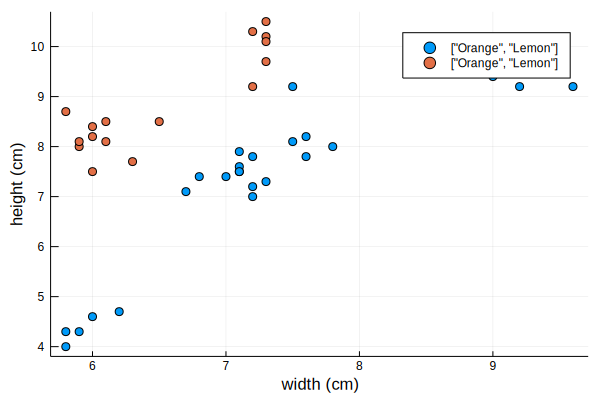

In [ ]:
orangeidx = findall(x -> x == :orange, labels)
lemonidx  = findall(x -> x == :lemon, labels)
scatter(
    [data[2, orangeidx], data[2, lemonidx]],
    [data[3, orangeidx], data[3, lemonidx]],
    labels=["Orange", "Lemon"], xlabel="width (cm)", ylabel="height (cm)")

## Neurons ##

The perceptron draws upon real-life neurons, thus it may be wise to give a brief characterisation of them.

![A diagram of hierarchical structure of structures in the human brain](https://www.researchgate.net/profile/Richard_Shine/publication/262149903/figure/fig1/AS:203137051828236@1425443055752/Hierarchical-neural-circuits-that-control-learning-in-the-human-brain-The-cortex-green.png)

[Image source](https://www.researchgate.net/figure/Hierarchical-neural-circuits-that-control-learning-in-the-human-brain-The-cortex-green_fig1_262149903)

![A diagram of a neuron](https://upload.wikimedia.org/wikipedia/commons/4/44/Neuron3.png)

[Image source](https://en.wikipedia.org/wiki/File:Neuron3.png)

![Neural voltage over time](https://upload.wikimedia.org/wikipedia/commons/e/e0/Spike_HH_2.png)

[Image source](https://en.wikipedia.org/wiki/File:Spike_HH_2.png)

## The perceptron “algorithm” ##

![Frank Rosenblatt and a colleague adjusting the wiring of an early perceptron](https://csis.pace.edu/~ctappert/srd2011/photos/Rosenblatt-CAL1958.jpg)

[Image source](http://csis.pace.edu/~ctappert/srd2011/rosenblatt-contributions.htm)

![Mark 1 Perceptron internal wiring](https://upload.wikimedia.org/wikipedia/en/5/52/Mark_I_perceptron.jpeg)

[Image source](https://en.wikipedia.org/wiki/File:Mark_I_perceptron.jpeg)

“The Navy last week demonstrated the embryo of an electronic computer named the Perceptron which, when completed in about a year, is expected to be the first non-living mechanism able to ‘perceive, recognize and identify its surroundings without human training or control.’” -- New York Times

[Source](https://www.nytimes.com/1958/07/13/archives/electronic-brain-teaches-itself.html)



### Formally… ###

$$ x = [x_0, \ldots, x_n] $$

$$ x \in \mathbb{R}^n $$

$$ w \in \mathbb{R}^n $$

$$ b \in \mathbb{R} $$

$$
f(x) = \begin{cases} 
      1 & w'x + b > 0 \\
      0 & else        \\
   \end{cases}
$$

In [ ]:
w = zeros(2)
b = 0.0
isorange(w, b, x) = w'x + b > 0

isorange(w, b, data[2:3, rand(orangeidx)])

false

In [ ]:
function accuracy(w, b)
    correct = 0
    for i in orangeidx
        isorange(w, b, data[2:3, i]) || continue
        correct += 1
    end
    for i in lemonidx
        !isorange(w, b, data[2:3, i]) || continue
        correct += 1
    end
    correct/(length(orangeidx) + length(lemonidx))*100
end

accuracy(w, b)

40.0

In [ ]:
using Random

epochs = 10
for iteration in 1:epochs
    for i in shuffle(vcat(orangeidx, lemonidx))
        x = data[2:3, i]
        isreallyorange = i in orangeidx
        isorange(w, b, x) != isreallyorange || continue
        if isreallyorange
            w .+= x
            b  += 1
        else
            w .-= x
            b  -= 1
        end
    end
end
accuracy(w, b)

65.0

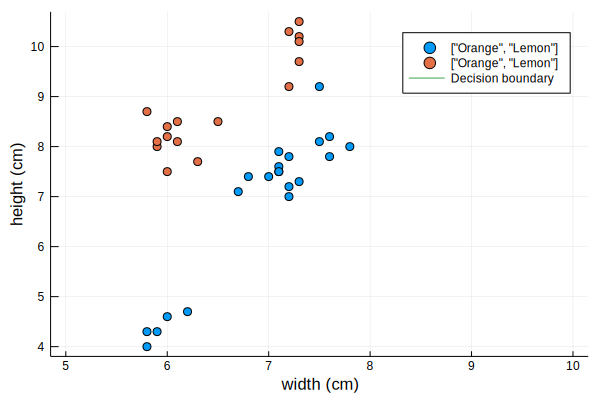

In [ ]:
plot = scatter(
    [data[2, orangeidx], data[2, lemonidx]],
    [data[3, orangeidx], data[3, lemonidx]],
    labels=["Orange", "Lemon"], xlabel="width (cm)", ylabel="height (cm)")
k = -(b/w[2])/(b/w[1])
d(x) = k*x + (-b/w[2])
plot!(deepcopy(plot), d, 5:10, label="Decision boundary")

### Attributes ###

1. Online
2. Linear


## Linear separability ##

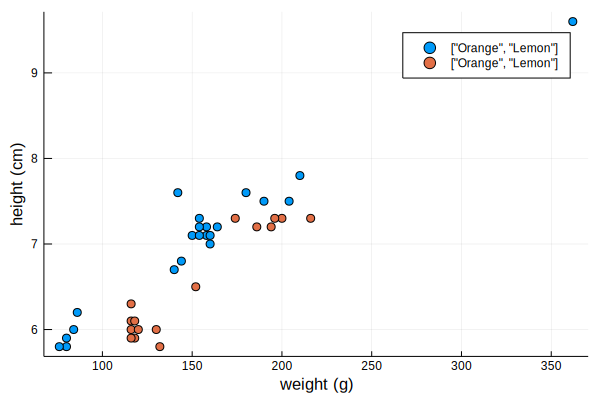

In [ ]:
scatter(
    [data[1, orangeidx], data[1, lemonidx]],
    [data[2, orangeidx], data[2, lemonidx]],
    labels=["Orange", "Lemon"], xlabel="weight (g)", ylabel="height (cm)")

In [ ]:
fill!(w, 0)
b = 0.0

function accuracy(w, b)
    correct = 0
    for i in orangeidx
        isorange(w, b, data[1:2, i]) || continue
        correct += 1
    end
    for i in lemonidx
        !isorange(w, b, data[1:2, i]) || continue
        correct += 1
    end
    correct/(length(orangeidx) + length(lemonidx))*100
end

epochs = 100
for iteration in 1:epochs
    for i in shuffle(vcat(orangeidx, lemonidx))
        x = data[1:2, i]
        reallyorange = i in orangeidx
        isorange(w, b, x) != reallyorange || continue
        if reallyorange
            w .+= x
            b  += 1
        else
            w .-= x
            b  -= 1
        end
    end
end
accuracy(w, b)

60.0

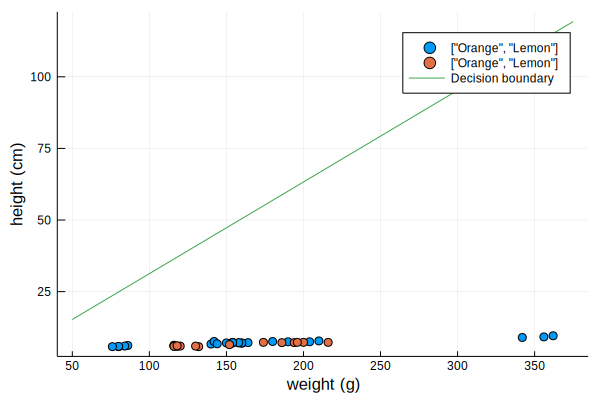

In [ ]:
plot = scatter(
    [data[1, orangeidx], data[1, lemonidx]],
    [data[2, orangeidx], data[2, lemonidx]],
    labels=["Orange", "Lemon"], xlabel="weight (g)", ylabel="height (cm)")
k = -(b/w[2])/(b/w[1])
d(x) = k*x + (-b/w[2])
plot!(deepcopy(plot), d, 50:375, label="Decision boundary")

## XOR ##

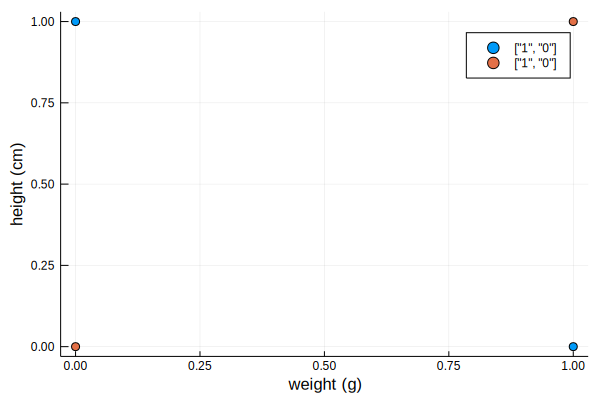

In [ ]:
scatter(
    [0 0; 1 1],
    [1 0; 0 1],
    labels=["1", "0"], xlabel="weight (g)", ylabel="height (cm)")

## End-of-lecture questions ##

1. Given that the perceptron algorithm only converges for linearly separable data, how can it still be applied to non-linear data?
2. The perceptron is a binary classification algorithm, how can one use it for cases where there is more than one than two classes?
3. If the perceptron and other similar approaches are “weaker” in comparison to deep models, why bother with them apart from educational or historical reasons? What are their advantages?

## Extracurricular reading ##

1. [“The perceptron: a probabilistic model for information storage and organization in the brain”](https://www.ling.upenn.edu/courses/cogs501/Rosenblatt1958.pdf) by Rosenblatt (1958)
2. [“Large margin classification using the perceptron algorithm”](https://cseweb.ucsd.edu/~yfreund/papers/LargeMarginsUsingPerceptron.pdf) by Freund and Schapire (1999) 